<a href="https://colab.research.google.com/github/Sin-wq/AI-Image-Classifier/blob/main/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing dependencies**

In [ ]:
# @title
!pip install tensorflow opencv-python matplotlib

In [ ]:
# @title
import tensorflow as tf
import os

In [ ]:
# @title
# Avoid OOM error by setting gpu growth consumption
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimenatl.set_memory_growth(gpu, True)

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

# **Remove Dodgy Images**

In [ ]:
# @title
import cv2
import imghdr

In [ ]:
# @title
data_dir = '/content/drive/MyDrive/Image Classifier Project/Data'

In [ ]:
# @title
image_exts = ['jpeg', 'bmp', 'png']

In [ ]:
# @title
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('image not in exts list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

# **Load Data**

In [ ]:
# @title
tf.data.Dataset

In [ ]:
# @title
import numpy as np
from matplotlib import pyplot as plt

In TensorFlow, a pipeline typically refers to the process of creating an efficient sequence of operations to handle data input, preprocessing, and feeding data into a machine learning model. Pipelines are crucial for managing the flow of data in a machine learning workflow, ensuring that data is processed and batched efficiently to maximize computational performance and streamline training or inference processes.

In [ ]:
# @title
#Builds labels and classes, etc.
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Image Classifier Project/Data')

In [ ]:
# @title
data_iterator = data.as_numpy_iterator()
# data.as_numpy_iterator()

In [ ]:
# @title
#Get Another Batch from iterator
batch = data_iterator.next()

In [ ]:
# @title
#Image represented as numpy
batch[0].shape

In [ ]:
# @title
#Class 1 - Sad People
#Class 0 - Happy People
batch[1]

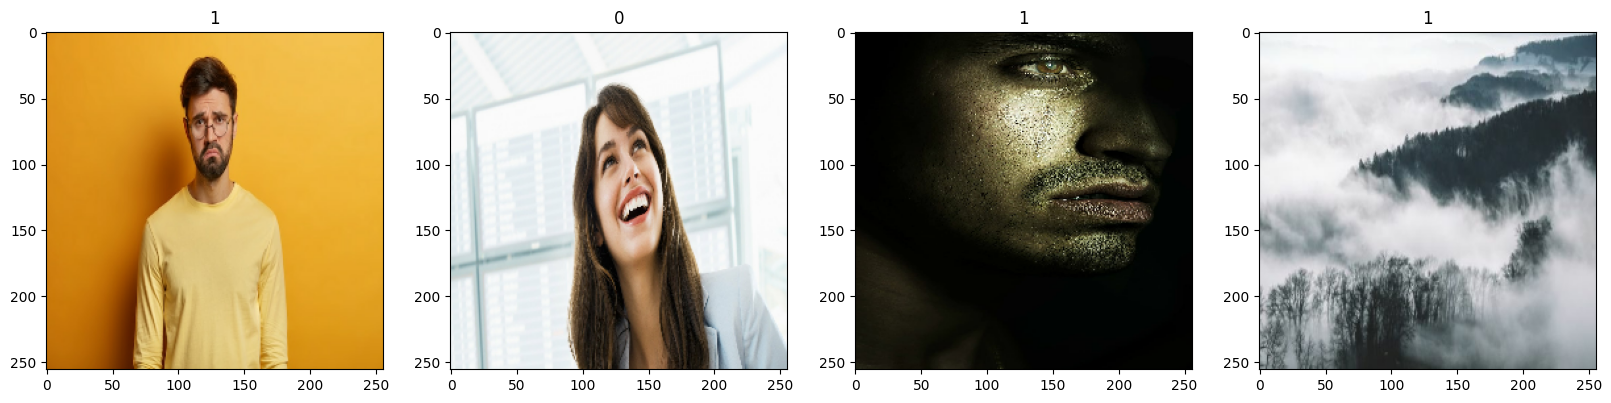

In [ ]:
# @title
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
# @title
batch[0].min()

In [ ]:
# @title
batch[0].max()

In [ ]:
# @title
scaled = batch[0] / 255

In [ ]:
# @title
scaled.min()
scaled.max()

# **Preprocess Data**

**Scale Data**

In [ ]:
# @title
data = data.map(lambda x, y :(x / 255, y))

In [ ]:
# @title
scaled_iterator = data.as_numpy_iterator()

In [ ]:
# @title
batch = scaled_iterator.next()

In [ ]:
# @title
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

**Split Data**

In [ ]:
# @title
len(data)

In [ ]:
# @title
#To train model
train_size = int(len(data)*.6)
#Evaluate our model while training
val_size = int(len(data)*.2)+1
#Used post training to do the evaluation
test_size = int(len(data)*.1)+1

In [ ]:
# @title
train_size+val_size+test_size

In [ ]:
# @title
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# **Deep Model**

**Building Deep Learning Model**

In [ ]:
# @title
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [ ]:
# @title
model = Sequential()

In [ ]:
# @title
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
# @title
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
# @title
model.summary()

**Train**

In [ ]:
# @title
logdir = '/content/drive/MyDrive/Image Classifier Project/logs'

In [ ]:
# @title
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# @title
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


**Plot Performance**

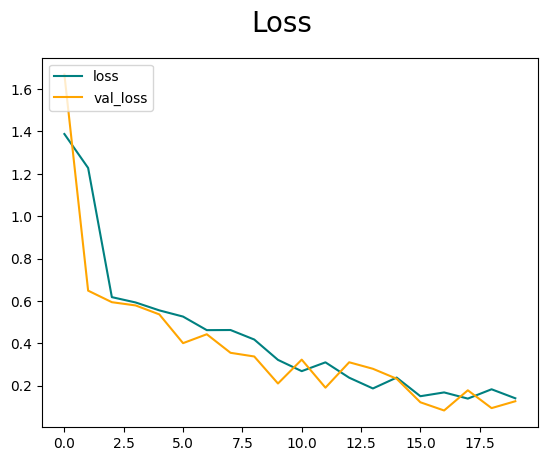

In [ ]:
# @title
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

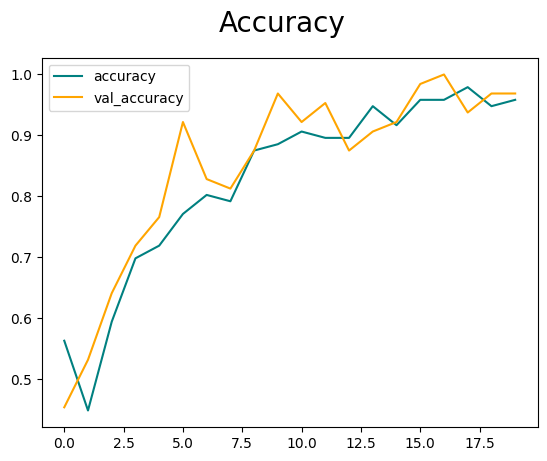

In [ ]:
# @title
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Evaluate Performance**

**Evaluate**

In [ ]:
# @title
from keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
# @title
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
# @title
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

In [ ]:
# @title
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, BinaryAccuracy:{acc.result().numpy()}')

**Test**

In [ ]:
# @title
img = cv2.imread ('/content/drive/MyDrive/Image Classifier Project/Test Data/abcde.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
# @title
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
# @title
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
# @title
print(yhat)
if yhat > 0.5:
  print(f'Prediction: Sad')
else:
  print(f'Prediction: Happy')

**Save Model**

In [ ]:
# @title
from keras.models import load_model

In [ ]:
# @title
model.save(os.path.join('/content/drive/MyDrive/Image Classifier Project/Models/happy_sad_model.h5'))

In [ ]:
# @title
new_model = load_model('/content/drive/MyDrive/Image Classifier Project/Models/happy_sad_model.h5')

In [ ]:
# @title
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
# @title
if yhatnew > 0.5:
  print(f'Prediction: Sad')
else:
  print(f'Prediction: Happy')